# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

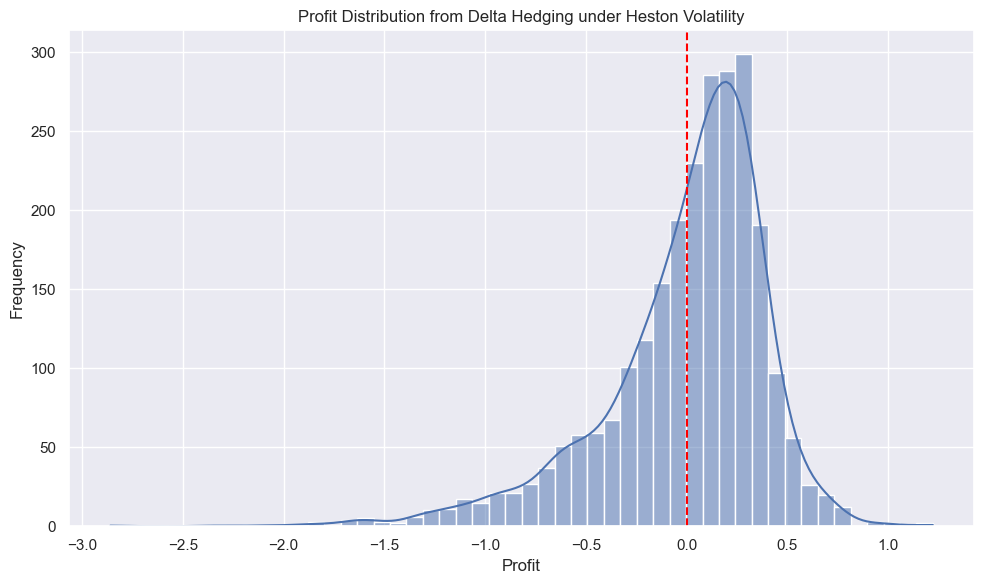

Mean Profit: -0.00
Std Dev of Profit: 0.41
% of Losses: 39.64%

1. Decreasing rho and theta can make the losses less than 50%.

2. If the strike price is below the spot price then we incur 100% losses.


In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# --- Heston Model Parameters ---
T = 1.0  # Time in years
N = 252  # Number of steps
dt = T / N  # Time step size
n_sim = 2500  # Number of simulated paths

S0 = 100      # Initial stock price
v0 = 0.05     # Initial variance
kappa = 4.0   # Speed of mean reversion
theta = 0.004  # Long-term variance
xi = 0.5      # Volatility of variance
rho = -0.9    # Correlation between asset and volatility
K = 150       # Strike price for option
r = 0.04       # Risk-free rate

# Function to simulate Heston model paths
def simulate_heston(S0, v0, kappa, theta, xi, rho, T, N, n_sim):
    dt = T / N
    S = np.zeros((n_sim, N + 1))
    v = np.zeros((n_sim, N + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, N + 1):
        Z1 = np.random.normal(size=n_sim) # Standard normal shock which affects the stock. Z1 > 0 means stock jumps upwards
                                          # and Z1 < 0 means stock jumps downwards.
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=n_sim) # Standard normal shock which affects the variance
        
 # vector of variances at time step t across all simulated paths
        v[:, t] = np.abs(v[:, t - 1] + kappa * (theta - v[:, t - 1]) * dt + xi * np.sqrt(v[:, t - 1] * dt) * Z1)

# the vector of stock prices at time step t across all simulated paths 
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * v[:, t - 1]) * dt + np.sqrt(v[:, t - 1] * dt) * Z2)

    return S, v

# Delta Hedging Strategy
from scipy.stats import norm

def black_scholes_delta(S, K, T, sigma, r, t):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

def simulate_hedging(S_paths, v_paths, K, r):
    n_paths, n_steps = S_paths.shape #n_paths = Number of simulated stock paths and n_steps = Number of time steps per path
                                     # S_paths gives simulated stock price paths under the Heston model
    dt = T / (n_steps - 1) # Time step size
    profits = np.zeros(n_paths) # After running the hedging strategy on each path, 
                                # profits[i] will store the profit or loss from hedging on the i-th simulated path

    for i in range(n_paths):
        S = S_paths[i]
        v = v_paths[i] # Simulated paths of the variance process
        cash = 0   # Money in the bank account
        shares = 0   # The number of stock shares held in the hedging portfolio at each time step
        for t in range(n_steps - 1):
            tau = T - t * dt
            sigma = np.sqrt(v[t])
            delta = black_scholes_delta(S[t], K, T, sigma, r, t * dt) # How many shares we should hold

            d_shares = delta - shares # Change in shares needed
            cash -= d_shares * S[t]  # Pay for change in shares
            shares = delta  # Update portfolio to new hedge ratio

            # cash grows at risk-free rate
            cash *= np.exp(r * dt)

        # Final portfolio value
        final_value = cash + shares * S[-1]
        option_payoff = max(S[-1] - K, 0)
        profits[i] = final_value - option_payoff

    return profits

# Run Simulation
S_paths, v_paths = simulate_heston(S0, v0, kappa, theta, xi, rho, T, N, n_sim)
profits = simulate_hedging(S_paths, v_paths, K, r)

# Plot Profit Distribution
plt.figure(figsize=(10, 6))
sns.histplot(profits, kde=True, bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title("Profit Distribution from Delta Hedging under Heston Volatility")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Summary Statistics
print("Mean Profit: {:.2f}".format(np.mean(profits)))
print("Std Dev of Profit: {:.2f}".format(np.std(profits)))
print("% of Losses: {:.2f}%".format(100 * np.mean(profits < 0)))

# Observations
print("\n1. Decreasing rho and theta can make the losses less than 50%.")
print("\n2. If the strike price is below the spot price then we incur 100% losses.")
